In [1]:
import cv2
import os
import torch,torchvision
import torch.nn as nn
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch.optim as optim
from torch.nn import *
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import wandb
from ray import tune
import os
torch.cuda.empty_cache()

In [2]:
device = 'cuda'
PROJECT_NAME = 'Landscape-Pictures-GAN'
IMG_SIZE = 224

In [3]:
def load_data(directory='./data/',img_size=IMG_SIZE,num_of_samples=500):
    idx = -1
    data = []
    for file in tqdm(os.listdir(directory)):
        idx += 1
        file = directory + file
        img = cv2.imread(file)
        img = cv2.resize(img,(img_size,img_size))
        data.append(img)
    print(idx)
    data = data[:num_of_samples]
    return torch.from_numpy(np.array(data))

In [4]:
# data = load_data()
# torch.save(data,'./data.pt')
# torch.save(data,'./data.pth')
data = torch.load('./data.pth')

In [5]:
data.shape

torch.Size([500, 224, 224, 3])

/home/indika/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


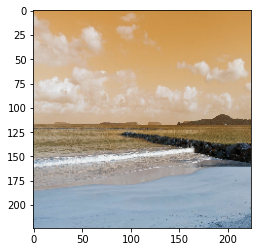

In [6]:
plt.imshow(torch.tensor(data[0]).view(IMG_SIZE,IMG_SIZE,3))

In [7]:
class Desc(nn.Module):
    def __init__(self,linearactivation=nn.LeakyReLU()):
        super().__init__()
        self.linearactivation = linearactivation
        self.linear1 = nn.Linear(IMG_SIZE*IMG_SIZE*3,2)
        self.linear1batchnorm = nn.BatchNorm1d(2)
        self.linear2 = nn.Linear(2,4)
        self.linear2batchnorm = nn.BatchNorm1d(4)
        self.linear3 = nn.Linear(4,2)
        self.linear3batchnorm = nn.BatchNorm1d(2)
        self.output = nn.Linear(2,1)
        self.outputactivation = nn.Sigmoid()
    
    def forward(self,X,shape=True):
        preds = self.linearactivation(self.linear1batchnorm(self.linear1(X)))
        preds = self.linearactivation(self.linear2batchnorm(self.linear2(preds)))
        preds = self.linearactivation(self.linear3batchnorm(self.linear3(preds)))
        preds = self.outputactivation(self.output(preds))
        return preds

In [ ]:
class Gen(nn.Module):
    def __init__(self,z_dim,linearactivation=nn.LeakyReLU()):
        super().__init__()
        self.linearactivation = linearactivation
        self.linear1 = nn.Linear(z_dim,256)
        self.linear1batchnorm = nn.BatchNorm1d(256)
        self.linear2 = nn.Linear(256,512)
        self.linear2batchnorm = nn.BatchNorm1d(512)
        self.linear3 = nn.Linear(512,256)
        self.linear3batchnorm = nn.BatchNorm1d(256)
        self.output = nn.Linear(256,IMG_SIZE*IMG_SIZE*3)
        self.outputactivation = nn.Tanh()
        
    def forward(self,X):
        preds = self.linearactivation(self.linear1batchnorm(self.linear1(X)))
        preds = self.linearactivation(self.linear2batchnorm(self.linear2(preds)))
        preds = self.linearactivation(self.linear3batchnorm(self.linear3(preds)))
        preds = self.outputactivation(self.output(preds))
        return preds

In [ ]:
z_dim = 64
BATCH_SIZE = 32
lr = 3e-4
criterion = nn.BCELoss()
epochs = 125
fixed_noise = torch.randn((BATCH_SIZE,z_dim)).to(device)

In [ ]:
gen = Gen(z_dim=z_dim).to(device)
optimizer_gen = optim.Adam(gen.parameters(),lr=lr)

In [ ]:
desc = Desc().to(device)
optimizer_desc = optim.Adam(desc.parameters(),lr=lr)

In [ ]:
def accuracy_fake(desc_fake):
    correct = 0
    total = 0
    preds = np.round(np.array(desc_fake.cpu().detach().numpy()))
    for pred in preds:
        if pred == 0:
            correct += 1
        total += 1
    return round(correct/total,3)
def accuracy_real(desc_real):
    correct = 0
    total = 0
    preds = np.round(np.array(desc_real.cpu().detach().numpy()))
    for pred in preds:
        if pred == 1:
            correct += 1
        total += 1
    return round(correct/total,3)

In [ ]:
torch.cuda.empty_cache()
msg = input('Msg : ') # 0.1-leaky-relu-desc
wandb.init(project=PROJECT_NAME,name=f'baseline-{msg}')
for epoch in tqdm(range(epochs)):
    torch.cuda.empty_cache()
    for idx in range(0,len(data),BATCH_SIZE):
        torch.cuda.empty_cache()
        X_batch = torch.tensor(np.array(data[idx:idx+BATCH_SIZE])).view(-1,IMG_SIZE*IMG_SIZE*3).to(device).float()
        batch_size = X_batch.shape[0]
        noise = torch.randn(batch_size, z_dim).to(device)
        fake = gen(noise).float()
        desc_real = desc(X_batch).view(-1)
        lossD_real = criterion(desc_real,torch.ones_like(desc_real))
        desc_fake = desc(fake).view(-1)
        lossD_fake = criterion(desc_fake,torch.zeros_like(desc_fake))
        lossD = (lossD_real+lossD_fake)/2
        desc.zero_grad()
        lossD.backward(retain_graph=True)
        wandb.log({'lossD':lossD.item()})
        optimizer_desc.step()
        output = desc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        wandb.log({'lossG':lossG.item()})
        lossG.backward()
        wandb.log({'lossG':lossG.item()})
        optimizer_gen.step()
        wandb.log({'accuracy_fake':accuracy_fake(desc_fake)})
        wandb.log({'accuracy_real':accuracy_real(desc_real)})
    with torch.no_grad():
        imgs = gen(fixed_noise).view(-1,3,IMG_SIZE,IMG_SIZE)
        imgs_all_grid = torchvision.utils.make_grid(imgs,normalize=True)
        wandb.log({'img':wandb.Image(imgs[0].cpu())})
        wandb.log({'imgs':wandb.Image(imgs_all_grid)})

Msg :  gen-starter-512


wandb: Currently logged in as: ranuga-d (use `wandb login --relogin` to force relogin)


 95%|█████████▌| 119/125 [02:57<00:08,  1.46s/it]